In [1]:
## disabeling warning msg
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush() # resolving tqdm problem


In [2]:
import torch
import numpy as np
from skimage import io, measure

In [3]:
def load_instance_labels(path):
    # label_img: H×W, each nucleus has unique id 1..N
    label_img = io.imread(path)
    return label_img

In [4]:
def validate_and_fix_boxes(boxes, labels, masks):
    """
    Filter invalid boxes AND return corresponding indices for masks.
    
    Args:
        boxes: [N, 4] numpy array
        labels: [N,] numpy array  
        masks: [N, H, W] numpy array
    Returns:
        valid_boxes: filtered boxes
        valid_labels: filtered labels
        valid_indices: indices of kept instances (for mask selection)
    """
    if len(boxes) == 0:
        return np.zeros((0, 4)), np.array([]), np.array([])
    
    # Check width and height
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]
    
    # Valid criteria
    valid = (widths > 0) & (heights > 0) & (widths < 10000) & (heights < 10000)
    
    if valid.sum() == 0:
        return np.zeros((0, 4)), np.array([]), np.array([])
    
    # Get indices of valid instances
    valid_indices = np.where(valid)[0]
    
    valid_boxes = boxes[valid]
    valid_labels = labels[valid]
    
    return valid_boxes, valid_labels, valid_indices


In [5]:
def instance_labels_to_masks_and_boxes(label_img, min_area=25):
    """
    Convert instance labels to masks/boxes, filter tiny objects.
    """
    instance_ids = np.unique(label_img)
    instance_ids = instance_ids[instance_ids != 0]

    masks_list = []
    boxes_list = []

    for inst_id in instance_ids:
        mask = (label_img == inst_id)
        area = mask.sum()
        
        # Skip tiny objects (likely noise)
        if area < min_area:
            continue
            
        masks_list.append(mask)
        
        # Bounding box
        coords = np.where(mask)
        if len(coords[0]) == 0:
            continue
        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()
        
        # Ensure valid box
        if x_max > x_min and y_max > y_min:
            boxes_list.append([x_min, y_min, x_max, y_max])

    if len(masks_list) == 0:
        return np.zeros((0, 4)), np.array([]), np.zeros((0, *label_img.shape), dtype=bool)
    
    masks = np.stack(masks_list, axis=0)
    boxes = np.array(boxes_list, dtype=np.float32)
    labels = np.ones((len(masks_list),), dtype=np.int64)
    
    return boxes, labels, masks


In [6]:
def debug_invalid_boxes(label_img_path):
    """Debug single image to find problematic nuclei"""
    label_img = load_instance_labels(label_img_path)
    boxes, labels, masks = instance_labels_to_masks_and_boxes(label_img)
    
    print(f"Found {len(boxes)} candidate nuclei")
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]
    
    invalid = (widths <= 0) | (heights <= 0)
    if invalid.sum() > 0:
        print("Invalid boxes:")
        for i in np.where(invalid)[0]:
            print(f"  Nucleus {i}: box={boxes[i]}, area={masks[i].sum()}")
    
    return boxes, labels, masks

# Run on problematic image
# debug_invalid_boxes("/kaggle/input/nuinsseg/human cerebellum/tissue images/human_cerebellum_1.png")


# Preparing Dataset for Masked RCNN

In [7]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from skimage import io
from scipy import ndimage

In [8]:
# import os
# import torch
# from torch.utils.data import Dataset
# from torchvision.transforms import functional as F
class NuInsSegMaskRCNNDataset(Dataset):
    """
    PyTorch Dataset for NuInsSeg compatible with torchvision Mask R-CNN.
    
    Args:
        image_paths: list of full paths to image files
        label_paths: list of full paths to label mask files
        transforms: optional transforms (must handle both image and target)
    """
    
    def __init__(self, image_paths, label_paths, transforms=None):
        assert len(image_paths) == len(label_paths), \
            f"Mismatch: {len(image_paths)} images vs {len(label_paths)} labels"
        
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transforms = transforms
        
        print(f"Dataset initialized with {len(self.image_paths)} samples")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        try:
            # Load image
            img = io.imread(img_path)
            
            # Handle grayscale → RGB
            if img.ndim == 2:
                img = np.stack([img, img, img], axis=-1)
            # Handle RGBA → RGB
            elif img.ndim == 3 and img.shape[-1] == 4:
                img = img[:, :, :3]
            # Handle other channel orders
            elif img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = np.transpose(img, (1, 2, 0))
                if img.shape[-1] == 4:
                    img = img[:, :, :3]
                elif img.shape[-1] == 1:
                    img = np.repeat(img, 3, axis=-1)
            
            # Load labels
            label_img = load_instance_labels(label_path)
            
            # Convert to masks/boxes
            boxes, labels, masks = instance_labels_to_masks_and_boxes(label_img)
            
            # Filter invalid boxes
            valid_boxes, valid_labels, valid_indices = validate_and_fix_boxes(
                boxes, labels, masks
            )
            
            # Convert image to tensor
            img_tensor = F.to_tensor(img)  # [3, H, W], float32, 0-1
            
            # Build target dict
            if len(valid_boxes) == 0:
                target = self._empty_target(img_tensor.shape[1], img_tensor.shape[2], idx)
            else:
                valid_masks = masks[valid_indices]
                
                boxes_tensor = torch.as_tensor(valid_boxes, dtype=torch.float32)
                labels_tensor = torch.as_tensor(valid_labels, dtype=torch.int64)
                masks_tensor = torch.as_tensor(valid_masks, dtype=torch.uint8)
                
                # Compute areas from masks (more accurate than box area)
                areas = torch.tensor([m.sum() for m in valid_masks], dtype=torch.float32)
                
                target = {
                    "boxes": boxes_tensor,
                    "labels": labels_tensor,
                    "masks": masks_tensor,
                    "image_id": torch.tensor([idx]),
                    "area": areas,
                    "iscrowd": torch.zeros((len(valid_labels),), dtype=torch.int64),
                }
            
            # Apply transforms if any
            if self.transforms is not None:
                img_tensor, target = self.transforms(img_tensor, target)
            
            return img_tensor, target
            
        except Exception as e:
            print(f"Error loading idx={idx}, path={img_path}: {e}")
            # Return fallback empty sample
            img_tensor = torch.zeros(3, 256, 256, dtype=torch.float32)
            return img_tensor, self._empty_target(256, 256, idx)

    def _empty_target(self, h, w, idx):
        """Create empty target dict for images with no valid nuclei."""
        return {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "masks": torch.zeros((0, h, w), dtype=torch.uint8),
            "image_id": torch.tensor([idx]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64),
        }

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_maskrcnn_model(num_classes=2):  # 1 class + background
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights="DEFAULT"  # pre-trained on COCO
    )

    # Replace box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model


In [22]:
import torch
from torch.utils.data import DataLoader
import torchvision

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# from glob import glob
from sklearn.model_selection import train_test_split

# --- A. Gather Files using your paths ---
# Use sorted() to ensure the order is deterministic!
# all_img_paths = sorted(glob.glob('../input/nuinsseg/*/tissue images/*.png'))
# all_label_paths = sorted(glob.glob('../input/nuinsseg/*/label masks/*.tif'))

all_img_paths = sorted(glob.glob('/kaggle/input/nuinsseg/human bladder/tissue images/*.png'))
all_label_paths = sorted(glob.glob('/kaggle/input/nuinsseg/human bladder/label masks modify/*.tif'))

# --- B. Sanity Check (Crucial!) ---
# Ensure we have the same number of images and labels
assert len(all_img_paths) == len(all_label_paths)
print(f"Total images found: {len(all_img_paths)}")

# Optional: Check if filenames match to ensure alignment
# (e.g. 'human_bladder_01.png' matches 'human_bladder_01.tif')
img_name_0 = os.path.splitext(os.path.basename(all_img_paths[0]))[0]
lbl_name_0 = os.path.splitext(os.path.basename(all_label_paths[0]))[0]
if img_name_0 != lbl_name_0:
    print(f"Warning: Filenames might not align: {img_name_0} vs {lbl_name_0}")

# --- C. Create Train/Val Split ---
# 80% Train, 20% Validation
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    all_img_paths, 
    all_label_paths, 
    test_size=0.2, 
    random_state=42 # Fixed seed for reproducibility
)

# --- D. Initialize Datasets ---
train_dataset = NuInsSegMaskRCNNDataset(train_imgs, train_lbls)
val_dataset   = NuInsSegMaskRCNNDataset(val_imgs, val_lbls)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")


train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn
)

model = get_maskrcnn_model(num_classes=2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 1

Total images found: 12
Dataset initialized with 9 samples
Dataset initialized with 3 samples
Train size: 9
Val size: 3


In [21]:

def find_nuinsseg_files(base_path):
    """
    Find all image and label file pairs in NuInsSeg dataset.
    
    Args:
        base_path: path to nuinsseg folder
    
    Returns:
        image_paths: list of image file paths
        label_paths: list of corresponding label file paths
    """
    image_paths = []
    label_paths = []
    
    # Find all tissue image folders
    tissue_dirs = glob.glob(os.path.join(base_path, "*/tissue images/"))
    
    if not tissue_dirs:
        # Try alternative structure
        tissue_dirs = glob.glob(os.path.join(base_path, "*/Tissue images/"))
    
    print(f"Found {len(tissue_dirs)} tissue directories")
    
    for tissue_dir in tissue_dirs:
        # Corresponding label directory
        parent = os.path.dirname(os.path.dirname(tissue_dir))
        label_dir = os.path.join(parent, "label masks modify")
        
        if not os.path.exists(label_dir):
            label_dir = os.path.join(parent, "Label masks modify")
        
        if not os.path.exists(label_dir):
            print(f"Warning: No label dir for {tissue_dir}")
            continue
        
        # Find all images
        img_files = glob.glob(os.path.join(tissue_dir, "*.png")) + \
                   glob.glob(os.path.join(tissue_dir, "*.tif")) + \
                   glob.glob(os.path.join(tissue_dir, "*.jpg"))
        
        for img_path in img_files:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            
            # Try different label extensions
            label_path = None
            for ext in ['.tif', '.tiff', '.png']:
                candidate = os.path.join(label_dir, img_name + ext)
                if os.path.exists(candidate):
                    label_path = candidate
                    break
            
            if label_path:
                image_paths.append(img_path)
                label_paths.append(label_path)
            else:
                print(f"Warning: No label for {img_name}")
    
    print(f"Found {len(image_paths)} image-label pairs")
    return image_paths, label_paths


def test_dataset(base_path="../input/nuinsseg"):
    """
    Test the dataset implementation.
    """
    print("=" * 60)
    print("TESTING NuInsSeg Mask R-CNN Dataset")
    print("=" * 60)
    
    # Step 1: Find files
    print("\n[1] Finding files...")
    image_paths, label_paths = find_nuinsseg_files(base_path)
    
    if len(image_paths) == 0:
        print("❌ No files found! Check your base_path.")
        print(f"   Tried: {base_path}")
        print(f"   Contents: {os.listdir(base_path) if os.path.exists(base_path) else 'PATH NOT FOUND'}")
        return None
    
    print(f"✅ Found {len(image_paths)} samples")
    print(f"   First image: {image_paths[0]}")
    print(f"   First label: {label_paths[0]}")
    
    # Step 2: Create dataset
    print("\n[2] Creating dataset...")
    dataset = NuInsSegMaskRCNNDataset(image_paths, label_paths)
    print(f"✅ Dataset created with {len(dataset)} samples")
    
    # Step 3: Test single item
    print("\n[3] Testing single item...")
    try:
        img, target = dataset[0]
        print(f"✅ Item loaded successfully!")
        print(f"   Image shape: {img.shape}")
        print(f"   Image dtype: {img.dtype}")
        print(f"   Image range: [{img.min():.3f}, {img.max():.3f}]")
        print(f"   Boxes shape: {target['boxes'].shape}")
        print(f"   Labels shape: {target['labels'].shape}")
        print(f"   Masks shape: {target['masks'].shape}")
        
        if len(target['boxes']) > 0:
            print(f"   First box: {target['boxes'][0].tolist()}")
            widths = target['boxes'][:, 2] - target['boxes'][:, 0]
            heights = target['boxes'][:, 3] - target['boxes'][:, 1]
            print(f"   All widths > 0: {(widths > 0).all().item()}")
            print(f"   All heights > 0: {(heights > 0).all().item()}")
        else:
            print("   (No nuclei in this image)")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # Step 4: Test DataLoader
    print("\n[4] Testing DataLoader...")
    try:
        loader = DataLoader(
            dataset, 
            batch_size=2, 
            shuffle=True, 
            collate_fn=collate_fn,
            num_workers=0  # Use 0 for debugging
        )
        
        images, targets = next(iter(loader))
        print(f"✅ DataLoader works!")
        print(f"   Batch size: {len(images)}")
        print(f"   Image shapes: {[img.shape for img in images]}")
        print(f"   Nuclei counts: {[len(t['boxes']) for t in targets]}")
    except Exception as e:
        print(f"❌ DataLoader error: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # Step 5: Test multiple samples
    print("\n[5] Testing 10 random samples...")
    import random
    test_indices = random.sample(range(len(dataset)), min(10, len(dataset)))
    
    success = 0
    total_nuclei = 0
    for idx in test_indices:
        try:
            img, target = dataset[idx]
            num_nuclei = len(target['boxes'])
            total_nuclei += num_nuclei
            
            # Validate boxes
            if num_nuclei > 0:
                widths = target['boxes'][:, 2] - target['boxes'][:, 0]
                heights = target['boxes'][:, 3] - target['boxes'][:, 1]
                assert (widths > 0).all(), "Invalid width"
                assert (heights > 0).all(), "Invalid height"
            
            success += 1
        except Exception as e:
            print(f"   ❌ Sample {idx} failed: {e}")
    
    print(f"✅ {success}/{len(test_indices)} samples loaded successfully")
    print(f"   Average nuclei per image: {total_nuclei/len(test_indices):.1f}")
    
    print("\n" + "=" * 60)
    print("ALL TESTS PASSED! Dataset is ready for training.")
    print("=" * 60)
    
    return dataset



test_dataset("../input/nuinsseg")

TESTING NuInsSeg Mask R-CNN Dataset

[1] Finding files...
Found 31 tissue directories
Found 665 image-label pairs
✅ Found 665 samples
   First image: ../input/nuinsseg/mouse muscle_tibia/tissue images/mouse_muscle_tibia_18.png
   First label: ../input/nuinsseg/mouse muscle_tibia/label masks modify/mouse_muscle_tibia_18.tif

[2] Creating dataset...
Dataset initialized with 665 samples
✅ Dataset created with 665 samples

[3] Testing single item...
✅ Item loaded successfully!
   Image shape: torch.Size([3, 512, 512])
   Image dtype: torch.float32
   Image range: [0.082, 0.733]
   Boxes shape: torch.Size([7, 4])
   Labels shape: torch.Size([7])
   Masks shape: torch.Size([7, 512, 512])
   First box: [362.0, 151.0, 390.0, 174.0]
   All widths > 0: True
   All heights > 0: True

[4] Testing DataLoader...
✅ DataLoader works!
   Batch size: 2
   Image shapes: [torch.Size([3, 512, 512]), torch.Size([3, 512, 512])]
   Nuclei counts: [15, 36]

[5] Testing 10 random samples...
✅ 10/10 samples load

In [23]:
import torch
import numpy as np
import cv2  # OpenCV for resizing
from tqdm.auto import tqdm

# --- Improved Dice Helper ---
def compute_dice_score(pred_mask, gt_mask):
    """
    Computes Dice score, handling shape mismatches automatically.
    """
    # 1. Check for Shape Mismatch and Resize if needed
    if pred_mask.shape != gt_mask.shape:
        # We always resize Prediction to match Ground Truth (to evaluate against reality)
        # using Nearest Neighbor interpolation (since masks are binary 0/1)
        h, w = gt_mask.shape
        pred_mask = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)
        
    # 2. Flatten and Compute
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    
    intersection = np.sum(pred_flat * gt_flat)
    return (2. * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)

# --- Main Evaluation Loop ---
dice_scores = []
model.eval()
device = next(model.parameters()).device

print("Starting robust evaluation...")
loader_bar = tqdm(val_loader, desc="Evaluating", unit="batch")

with torch.no_grad():
    for images, targets in loader_bar:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, out in enumerate(outputs):
            # --- 1. Process Prediction ---
            scores = out["scores"].cpu().numpy()
            
            # Filter low confidence predictions
            keep_idx = scores > 0.5 
            pred_masks_raw = out["masks"][keep_idx] # [K, 1, H, W]
            
            # Combine instances into one semantic map (2D)
            if len(pred_masks_raw) > 0:
                pred_masks_np = pred_masks_raw.squeeze(1).cpu().numpy()
                # Max projection to combine instances
                combined_pred = np.max(pred_masks_np, axis=0)
                # Binarize (0 or 1)
                combined_pred = (combined_pred > 0.5).astype(np.uint8)
            else:
                # Handle empty detection case
                # We use the shape of the FIRST image channel to guess dimensions 
                # or fallback to 256x256 if needed.
                # However, the compute_dice_score will handle the resize anyway.
                # Let's create a placeholder based on input image size
                img_h, img_w = images[i].shape[-2:] 
                combined_pred = np.zeros((img_h, img_w), dtype=np.uint8)

            # --- 2. Process Ground Truth ---
            gt_masks_raw = targets[i]["masks"].cpu().numpy()
            
            if len(gt_masks_raw) > 0:
                combined_gt = np.max(gt_masks_raw, axis=0).astype(np.uint8)
            else:
                # Create empty mask with same size as prediction to avoid errors
                combined_gt = np.zeros_like(combined_pred)

            # --- 3. Compute Dice with Safety Check ---
            d = compute_dice_score(combined_pred, combined_gt)
            dice_scores.append(d)
            
            # Update bar
            loader_bar.set_postfix(MeanDice=np.mean(dice_scores))

print(f"\nFinal Mean Dice Score: {np.mean(dice_scores):.4f}")

Starting robust evaluation...


Evaluating:   0%|          | 0/2 [00:00<?, ?batch/s]


Final Mean Dice Score: 0.1556


In [24]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    skipped_images = 0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        
        # Validate targets before moving to GPU
        valid_targets = []
        for target in targets:
            if len(target["boxes"]) > 0 and (target["boxes"][:, 3] - target["boxes"][:, 1]).min() > 0:
                valid_targets.append({k: v.to(device) for k, v in target.items()})
            else:
                skipped_images += 1
        
        if len(valid_targets) == 0:
            continue
            
        targets = valid_targets
        
        loss_dict = model(images[:len(targets)], targets)  # Match image/target lengths
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}, valid_targets={len(valid_targets)}/{len(targets)}")
    
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}, skipped={skipped_images}")


Batch 0, valid_targets=2/2
Epoch 1: loss=3.1100, skipped=0


In [ ]:
# Create a directory for models if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

save_path = "models/maskrcnn_nuinsseg_best.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

##Already Saved in previous run
##16-20 epochs enough

model.load_state_dict(torch.load('/kaggle/input/maskrcnn-nuinsseg/pytorch/default/1/maskrcnn_nuinsseg_best.pth'))

model.eval()
model.to(device)

In [26]:
## After Fine Tuning
# --- Improved Dice Helper ---
def compute_dice_score(pred_mask, gt_mask):
    """
    Computes Dice score, handling shape mismatches automatically.
    """
    # 1. Check for Shape Mismatch and Resize if needed
    if pred_mask.shape != gt_mask.shape:
        # We always resize Prediction to match Ground Truth (to evaluate against reality)
        # using Nearest Neighbor interpolation (since masks are binary 0/1)
        h, w = gt_mask.shape
        pred_mask = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)
        
    # 2. Flatten and Compute
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    
    intersection = np.sum(pred_flat * gt_flat)
    return (2. * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)

# --- Main Evaluation Loop ---
dice_scores = []
model.eval()
device = next(model.parameters()).device

print("Starting robust evaluation...")
loader_bar = tqdm(val_loader, desc="Evaluating", unit="batch")

with torch.no_grad():
    for images, targets in loader_bar:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, out in enumerate(outputs):
            # --- 1. Process Prediction ---
            scores = out["scores"].cpu().numpy()
            
            # Filter low confidence predictions
            keep_idx = scores > 0.5 
            pred_masks_raw = out["masks"][keep_idx] # [K, 1, H, W]
            
            # Combine instances into one semantic map (2D)
            if len(pred_masks_raw) > 0:
                pred_masks_np = pred_masks_raw.squeeze(1).cpu().numpy()
                # Max projection to combine instances
                combined_pred = np.max(pred_masks_np, axis=0)
                # Binarize (0 or 1)
                combined_pred = (combined_pred > 0.5).astype(np.uint8)
            else:
                # Handle empty detection case
                # We use the shape of the FIRST image channel to guess dimensions 
                # or fallback to 256x256 if needed.
                # However, the compute_dice_score will handle the resize anyway.
                # Let's create a placeholder based on input image size
                img_h, img_w = images[i].shape[-2:] 
                combined_pred = np.zeros((img_h, img_w), dtype=np.uint8)

            # --- 2. Process Ground Truth ---
            gt_masks_raw = targets[i]["masks"].cpu().numpy()
            
            if len(gt_masks_raw) > 0:
                combined_gt = np.max(gt_masks_raw, axis=0).astype(np.uint8)
            else:
                # Create empty mask with same size as prediction to avoid errors
                combined_gt = np.zeros_like(combined_pred)

            # --- 3. Compute Dice with Safety Check ---
            d = compute_dice_score(combined_pred, combined_gt)
            dice_scores.append(d)
            
            # Update bar
            loader_bar.set_postfix(MeanDice=np.mean(dice_scores))

print(f"\nFinal Mean Dice Score: {np.mean(dice_scores):.4f}")

Starting robust evaluation...


Evaluating:   0%|          | 0/2 [00:00<?, ?batch/s]


Final Mean Dice Score: 0.5293


In [27]:
import torch
import numpy as np
import cv2  # OpenCV for resizing
from tqdm.auto import tqdm

# --- 1. IoU Helper (Calculates Overlap Matrix) ---
def compute_iou_batch(masks1, masks2):
    """
    Computes IoU overlaps between two sets of masks.
    masks1: [N, H, W] (Ground Truth)
    masks2: [M, H, W] (Prediction)
    Returns: [N, M] matrix of IoU scores.
    """
    if masks1.size == 0 or masks2.size == 0:
        return np.zeros((len(masks1), len(masks2)))
        
    # Flatten spatial dims: [N, H*W] and [M, H*W]
    m1 = masks1.reshape(masks1.shape[0], -1).astype(bool)
    m2 = masks2.reshape(masks2.shape[0], -1).astype(bool)
    
    # Intersection: logical AND (Matrix Multiplication)
    intersection = np.matmul(m1.astype(np.uint8), m2.astype(np.uint8).T)
    
    # Union: sum of areas - intersection
    area1 = m1.sum(axis=1)[:, None] # [N, 1]
    area2 = m2.sum(axis=1)[None, :] # [1, M]
    union = area1 + area2 - intersection
    
    iou = intersection / (union + 1e-6)
    return iou, intersection, union

# --- 2. Dice Helper (Your Improved Version) ---
def compute_dice_score(pred_mask, gt_mask):
    # 1. Check for Shape Mismatch and Resize
    if pred_mask.shape != gt_mask.shape:
        h, w = gt_mask.shape
        pred_mask = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)
        
    # 2. Flatten and Compute
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    return (2. * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)

# --- 3. AJI & PQ Helper (With Resizing) ---
def compute_aji_pq_instance(pred_masks, gt_masks):
    """
    Calculates AJI and PQ, handling shape mismatches for instances.
    pred_masks: [M, H_pred, W_pred]
    gt_masks:   [N, H_gt, W_gt]
    """
    # --- HANDLE RESIZING FOR INSTANCES ---
    # If dimensions differ, resize all pred instances to match GT
    if len(pred_masks) > 0 and len(gt_masks) > 0:
        if pred_masks[0].shape != gt_masks[0].shape:
            h, w = gt_masks[0].shape
            # Resize every instance mask individually
            pred_masks = np.array([
                cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST) 
                for m in pred_masks
            ])

    # Handle empty cases
    if len(gt_masks) == 0:
        return (1.0, 1.0) if len(pred_masks) == 0 else (0.0, 0.0)
    if len(pred_masks) == 0:
        return 0.0, 0.0

    # Get IoU Matrix
    iou_matrix, intersect_matrix, union_matrix = compute_iou_batch(gt_masks, pred_masks)
    
    # --- AJI Calculation ---
    overall_inter = 0
    overall_union = 0
    pred_used = np.zeros(len(pred_masks), dtype=bool)
    
    for i in range(len(gt_masks)):
        best_pred_idx = np.argmax(iou_matrix[i])
        best_iou = iou_matrix[i, best_pred_idx]
        
        if best_iou > 0: # Strict AJI usually matches if overlap > 0
            overall_inter += intersect_matrix[i, best_pred_idx]
            overall_union += union_matrix[i, best_pred_idx]
            pred_used[best_pred_idx] = True
        else:
            overall_union += gt_masks[i].sum()
            
    # Add unmatched predictions to Union
    for idx in np.where(~pred_used)[0]:
        overall_union += pred_masks[idx].sum()
        
    aji = overall_inter / (overall_union + 1e-6)

    # --- PQ Calculation ---
    tp, fp, fn = 0, 0, 0
    iou_sum = 0
    pq_pred_matched = np.zeros(len(pred_masks), dtype=bool)
    
    for i in range(len(gt_masks)):
        best_pred_idx = np.argmax(iou_matrix[i])
        best_iou = iou_matrix[i, best_pred_idx]
        
        # PQ Threshold is strictly 0.5
        if best_iou > 0.5:
            tp += 1
            iou_sum += best_iou
            pq_pred_matched[best_pred_idx] = True
        else:
            fn += 1 
            
    fp = len(pred_masks) - np.sum(pq_pred_matched)
    
    sq = iou_sum / (tp + 1e-6)
    rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-6)
    pq = sq * rq
    
    return aji, pq

# --- Main Evaluation Loop ---
dice_scores = []
aji_scores = []
pq_scores = []

model.eval()
device = next(model.parameters()).device

print("Starting robust evaluation with Dice, AJI, and PQ...")
loader_bar = tqdm(val_loader, desc="Evaluating", unit="batch")

with torch.no_grad():
    for images, targets in loader_bar:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, out in enumerate(outputs):
            # --- 1. Process Prediction ---
            scores = out["scores"].cpu().numpy()
            keep_idx = scores > 0.5 
            
            # Get Instance Masks (needed for AJI/PQ)
            pred_masks_raw = out["masks"][keep_idx]
            
            if len(pred_masks_raw) > 0:
                # [N, 1, H, W] -> [N, H, W]
                pred_masks_np = pred_masks_raw.squeeze(1).cpu().numpy()
                pred_masks_np = (pred_masks_np > 0.5).astype(np.uint8)
                
                # Combine for Dice (Semantic)
                combined_pred = np.max(pred_masks_np, axis=0)
            else:
                pred_masks_np = np.array([], dtype=np.uint8)
                # Placeholder for Dice
                img_h, img_w = images[i].shape[-2:] 
                combined_pred = np.zeros((img_h, img_w), dtype=np.uint8)

            # --- 2. Process Ground Truth ---
            gt_masks_raw = targets[i]["masks"].cpu().numpy().astype(np.uint8)
            
            if len(gt_masks_raw) > 0:
                combined_gt = np.max(gt_masks_raw, axis=0).astype(np.uint8)
            else:
                combined_gt = np.zeros_like(combined_pred)

            # --- 3. Compute Metrics ---
            
            # A. Dice (Semantic)
            # (Your function handles resizing internally)
            d = compute_dice_score(combined_pred, combined_gt)
            dice_scores.append(d)
            
            # B. AJI & PQ (Instance)
            # (My function handles resizing internally)
            aji, pq = compute_aji_pq_instance(pred_masks_np, gt_masks_raw)
            aji_scores.append(aji)
            pq_scores.append(pq)
            
            # Update bar
            loader_bar.set_postfix(
                Dice=f"{np.mean(dice_scores):.3f}", 
                AJI=f"{np.mean(aji_scores):.3f}",
                PQ=f"{np.mean(pq_scores):.3f}"
            )

print("\n" + "="*30)
print(f"Final Mean Dice: {np.mean(dice_scores):.4f}")
print(f"Final Mean AJI:  {np.mean(aji_scores):.4f}")
print(f"Final Mean PQ:   {np.mean(pq_scores):.4f}")
print("="*30)

Starting robust evaluation with Dice, AJI, and PQ...


Evaluating:   0%|          | 0/2 [00:00<?, ?batch/s]


Final Mean Dice: 0.5293
Final Mean AJI:  0.0674
Final Mean PQ:   0.0231


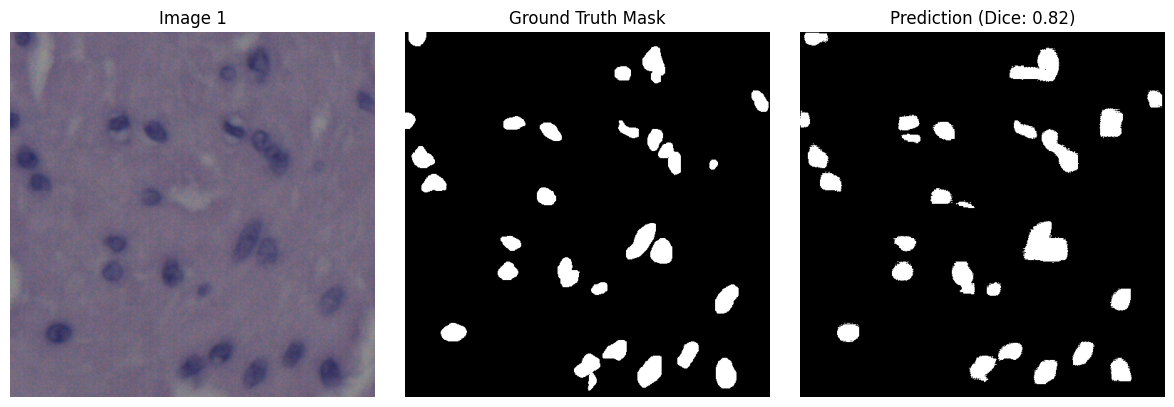

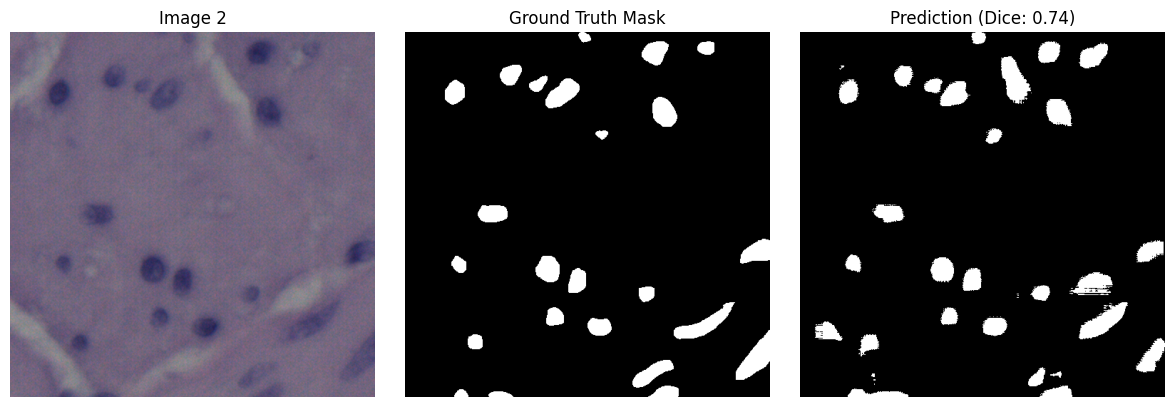

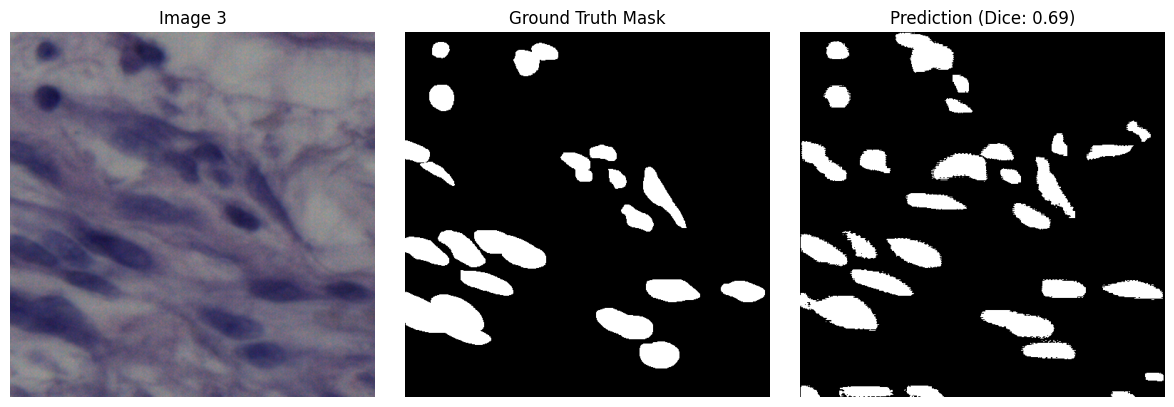


Overall Mean Dice Score: 0.7499


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def compute_dice_score(pred_mask, gt_mask):
    # Flatten
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    return (2. * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)

dice_scores = []
num_shown = 0  # Counter to limit visualization

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        # Move images to device
        images_device = [img.to(device) for img in images]
        outputs = model(images_device)

        for i, out in enumerate(outputs):
            # --- 1. Process Prediction ---
            # Threshold soft masks to binary (0 or 1)
            pred_masks = out["masks"] > 0.5  # [N, 1, H, W]
            pred_masks = pred_masks.squeeze(1).cpu().numpy()
            
            # Combine all instances into one semantic map (using max projection)
            if len(pred_masks) > 0:
                combined_pred = np.max(pred_masks, axis=0).astype(np.uint8)
            else:
                # Handle case where model detects nothing
                combined_pred = np.zeros((images[i].shape[1], images[i].shape[2]), dtype=np.uint8)
            
            # --- 2. Process Ground Truth ---
            gt_masks = targets[i]["masks"].cpu().numpy() # [N, H, W]
            # Combine instances into one map
            if len(gt_masks) > 0:
                combined_gt = np.max(gt_masks, axis=0).astype(np.uint8)
            else:
                combined_gt = np.zeros_like(combined_pred)

            # --- 3. Calculate Dice ---
            d = compute_dice_score(combined_pred, combined_gt)
            dice_scores.append(d)
            
            # --- 4. Visualization (Limit to first 5 images) ---
            if num_shown < 5:
                # Prepare Image for plotting (C, H, W) -> (H, W, C)
                # Note: We use images[i] (CPU tensor) not images_device[i]
                img_display = images[i].permute(1, 2, 0).numpy()
                
                # Normalize if necessary (if your transforms normalized to not 0-1)
                # img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                
                # Plot Original Image
                axes[0].imshow(img_display)
                axes[0].set_title(f"Image {num_shown+1}")
                axes[0].axis('off')
                
                # Plot Ground Truth
                axes[1].imshow(combined_gt, cmap='gray')
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis('off')
                
                # Plot Prediction
                axes[2].imshow(combined_pred, cmap='gray')
                axes[2].set_title(f"Prediction (Dice: {d:.2f})")
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                num_shown += 1

print(f"\nOverall Mean Dice Score: {np.mean(dice_scores):.4f}")